# **1: Installations**

In [1]:
!pip install --no-cache-dir rasterio kornia torch torchvision Pillow scikit-learn pandas tqdm matplotlib torchgeo -q
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 303.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 313.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 318.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 312.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 317.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 314.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 308.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 335.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 325.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.6/851.6 kB 372.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 350.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# **2: Training Data Download**

In [2]:
!wget --no-check-certificate https://madm.dfki.de/files/sentinel/EuroSATallBands.zip -O EuroSATallBands.zip
!unzip -q EuroSATallBands.zip -d EuroSAT


--2025-05-17 16:48:30--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  16.4MB/s    in 2m 6s   

2025-05-17 16:50:37 (15.6 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



# **3: Convert .tif to .npy and band selection**

In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm

def convert_selected_bands_with_ndvi(
    src_root="EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif",
    dst_root="EuroSAT_npy_AllBands_NDVI"
):
    os.makedirs(dst_root, exist_ok=True)
    # All bands except B10 (index 9)
    selected_indices = [1,2,3,4,5,6,7,8,10,11,12]  # B1-B9, B11-B8a

    for class_name in tqdm(os.listdir(src_root)):
        src_class_path = os.path.join(src_root, class_name)
        dst_class_path = os.path.join(dst_root, class_name)
        os.makedirs(dst_class_path, exist_ok=True)

        for fname in os.listdir(src_class_path):
            if not fname.endswith(".tif"):
                continue
            path = os.path.join(src_class_path, fname)
            out_path = os.path.join(dst_class_path, fname.replace(".tif", ".npy"))

            try:
                with rasterio.open(path) as src:
                    img = src.read()
                    img = np.clip(img, 0, 10000).astype(np.float32)

                    # Raw bands (scaled to 0‑1)
                    raw_bands = img[selected_indices] / 10000.0

                    # Indices
                    B3, B4, B8, B11 = img[2], img[3], img[7], img[11]   # note: indices w.r.t selected set
                    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
                    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
                    ndbi = (B11 - B8) / (B11 + B8 + 1e-6)
                    ndmi = (B8 - B11) / (B8 + B11 + 1e-6)
                    savi = (1.5 * (B8 - B4)) / (B8 + B4 + 0.5)

                    indices = np.stack([ndvi, ndwi, ndbi, ndmi, savi], axis=0)
                    indices = np.clip(indices, -1, 1)

                    final = np.concatenate([raw_bands, indices], axis=0).astype(np.float32)
                    np.save(out_path, final)

            except Exception as e:
                print(f" Failed: {fname} | {e}")

    print(f" NPY files saved in {dst_root}")

convert_selected_bands_with_ndvi()


100%|██████████| 10/10 [01:23<00:00,  8.39s/it]

 NPY files saved in EuroSAT_npy_AllBands_NDVI


# **4: Dataset Preparation and Exploratory Data Analysis (EDA)**

# **4.1: Build Dataset Index + Compute Mean/Std**

In [4]:
import pandas as pd

def build_dataset_index(npy_root="EuroSAT_npy_AllBands_NDVI"):
    rows = []
    classes = sorted(os.listdir(npy_root))
    for cls in classes:
        for fname in os.listdir(os.path.join(npy_root, cls)):
            if fname.endswith(".npy"):
                rows.append({
                    "path": os.path.join(npy_root, cls, fname),
                    "label": cls
                })
    df = pd.DataFrame(rows)
    df['label_idx'] = df['label'].astype('category').cat.codes
    return df

df = build_dataset_index()

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

def compute_mean_std(df):
    channel_sum = 0
    channel_squared_sum = 0
    total_pixels = 0

    for path in tqdm(df['path'], desc="Computing mean/std"):
        arr = np.load(path)
        c, h, w = arr.shape
        channel_sum += arr.sum(axis=(1, 2))
        channel_squared_sum += (arr ** 2).sum(axis=(1, 2))
        total_pixels += h * w

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_squared_sum / total_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(df)
print("Mean:", mean)
print("Std:", std)


Computing mean/std: 100%|██████████| 27000/27000 [00:07<00:00, 3619.53it/s]

Mean: [0.11171499746817129, 0.10418191189236112, 0.09464434136284722, 0.11991249819155092, 0.20029204644097223, 0.23738859953703703, 0.2301081814236111, 0.07321806731047453, 0.1820584129050926, 0.11181183991608797, 0.2599645724826389, 0.34858626302083334, -0.2825516312210648, -0.398821361400463, 0.398821361400463, 0.49681297019675924]
Std: [0.0331412106567792, 0.039304786716508194, 0.0591837754996822, 0.05657120452424666, 0.0859749690772532, 0.10856433735814561, 0.11165509330400628, 0.04037296496532537, 0.1001344254662369, 0.07593353634636446, 0.1230235462965785, 0.33000506587978096, 0.3387875009563799, 0.27285057324321954, 0.27285057324321954, 0.46377632071240255]


# **4.2: Dataset Class Visualization**

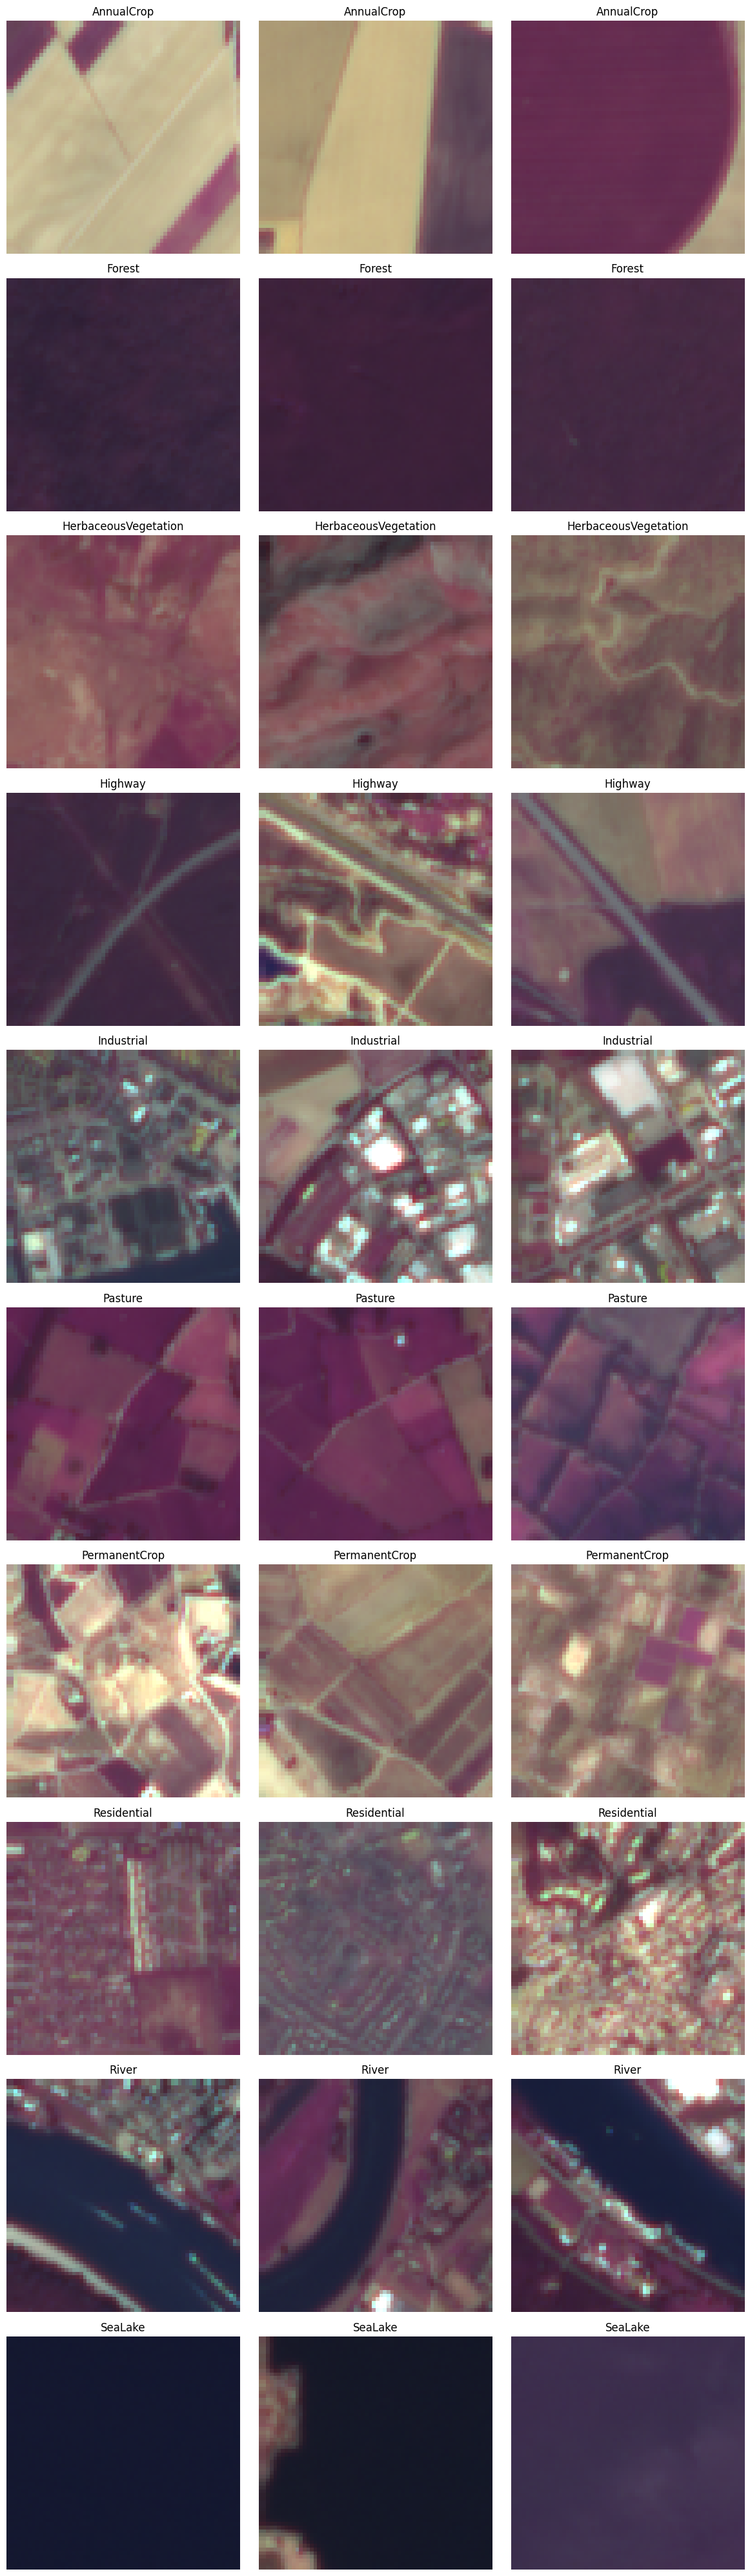

In [5]:
# Add after the dataset creation
import matplotlib.pyplot as plt

def visualize_classes(dataframe, npy_root="EuroSAT_npy_AllBands_NDVI", num_per_class=1):
    classes = sorted(dataframe['label'].unique())
    fig, axes = plt.subplots(len(classes), num_per_class, figsize=(4*num_per_class, 4*len(classes)))
    
    for i, class_name in enumerate(classes):
        class_samples = dataframe[dataframe['label'] == class_name]['path'].tolist()[:num_per_class]
        
        for j, sample_path in enumerate(class_samples):
            # Load the .npy file
            sample = np.load(sample_path)
            
            # Use RGB-like combination of bands (B4, B3, B2) for visualization
            # These correspond to Red, Green, Blue bands
            rgb_img = np.stack([
                sample[3],  # Red band (B4)
                sample[2],  # Green band (B3)
                sample[1],  # Blue band (B2)
            ], axis=2)
            
            # Normalize for visualization
            rgb_img = np.clip(rgb_img * 3.5, 0, 1)  # Enhance brightness
            
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(rgb_img)
            ax.set_title(class_name)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize one sample per class
visualize_classes(df, num_per_class=3)

# **4.3: Spectral Band Visualization**

Visualizing bands for: AnnualCrop


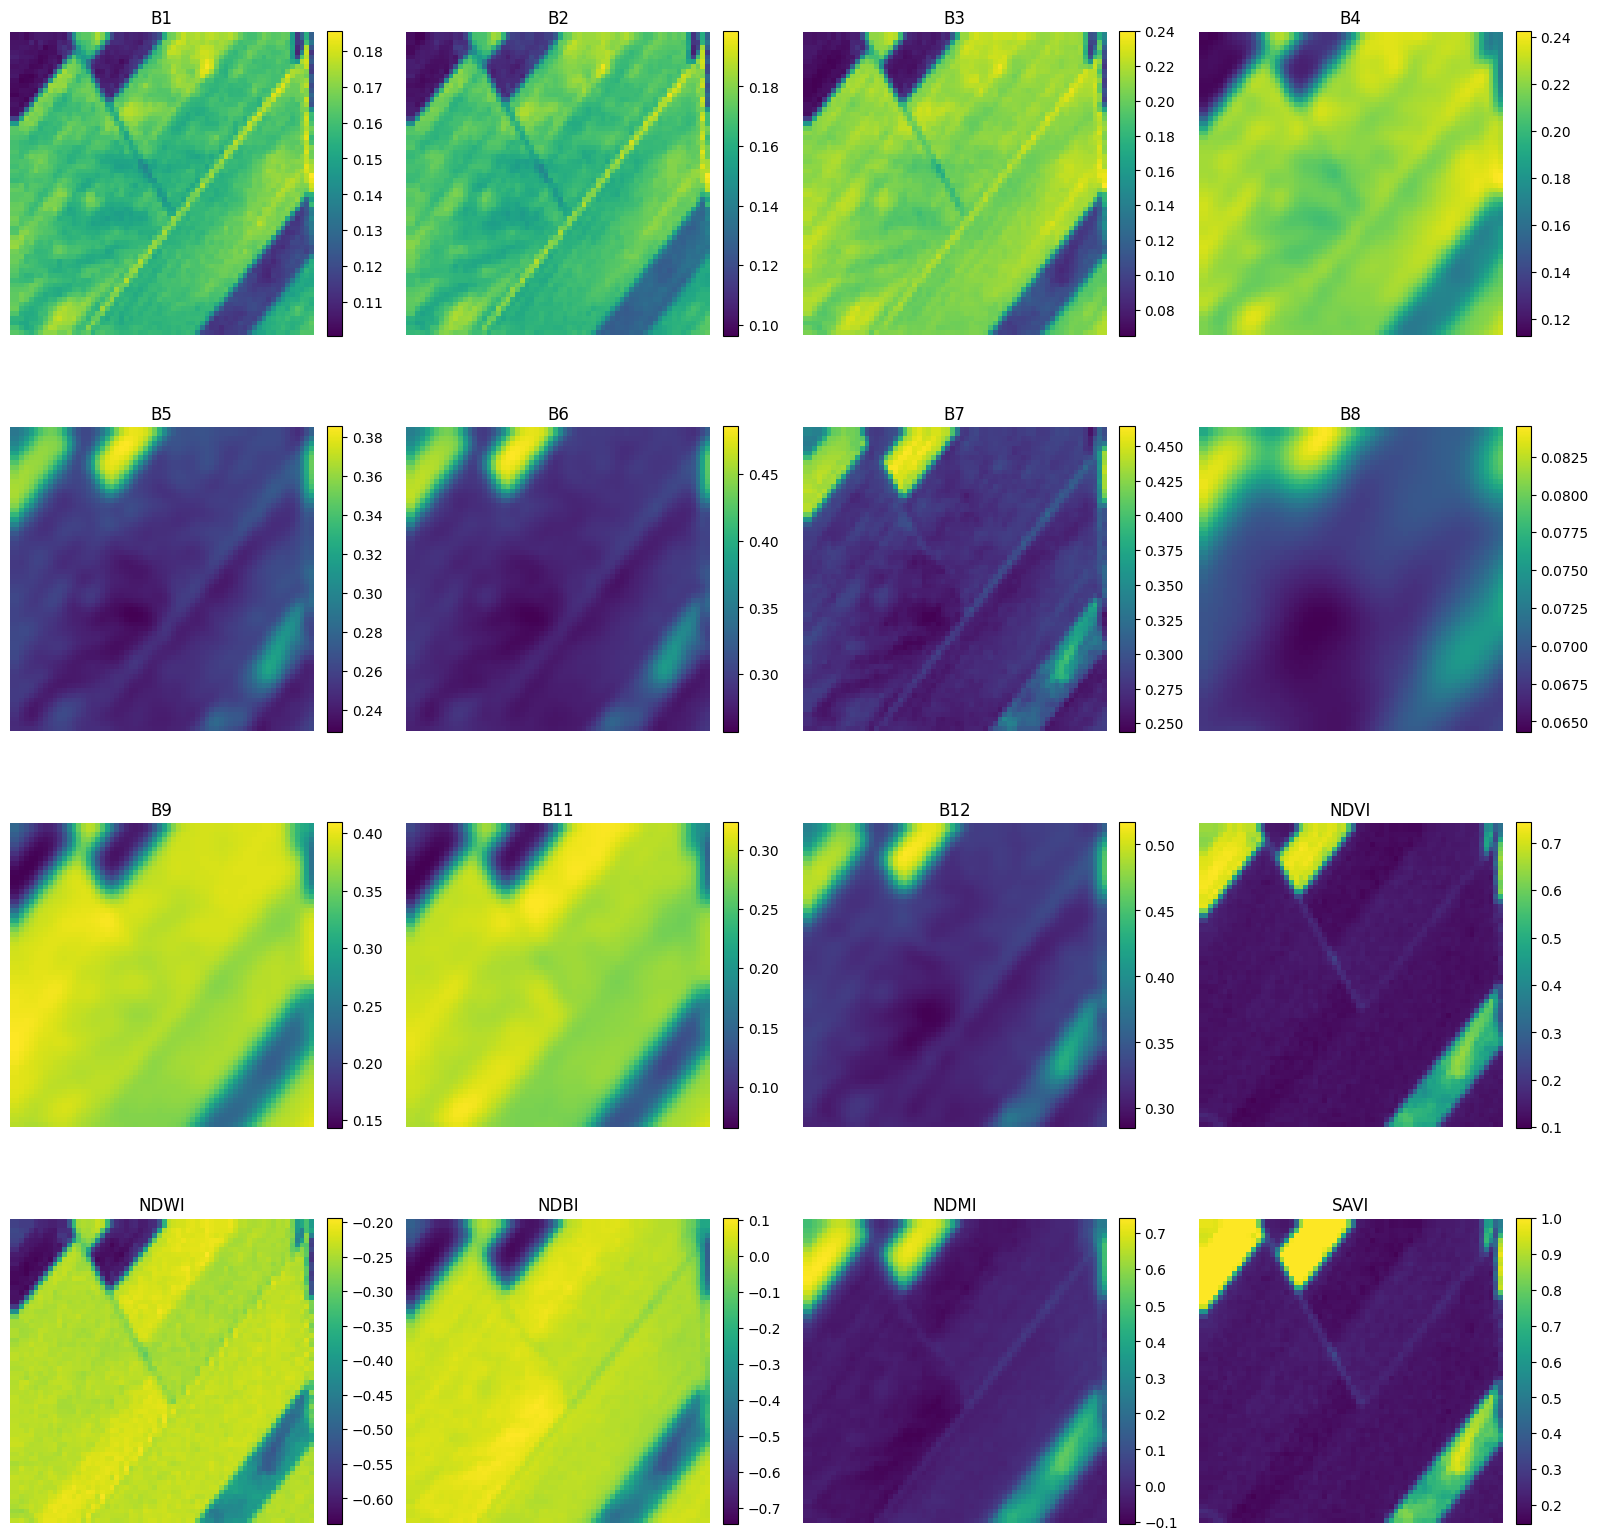

In [6]:
# Add after loading the dataset
def visualize_spectral_bands(sample_path):
    """Visualize different spectral bands of a single sample"""
    sample = np.load(sample_path)
    
    # Define band names
    band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 
                  'B7', 'B8', 'B9', 'B11', 'B12', 
                  'NDVI', 'NDWI', 'NDBI', 'NDMI', 'SAVI']
    
    # Plot the first 16 channels (raw bands + indices)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    for i in range(min(16, sample.shape[0])):
        im = axes[i].imshow(sample[i], cmap='viridis')
        axes[i].set_title(band_names[i])
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Pick a sample image
sample_path = df.iloc[0]['path']
print(f"Visualizing bands for: {df.iloc[0]['label']}")
visualize_spectral_bands(sample_path)

# **4.4: Class Distribution Visualization**

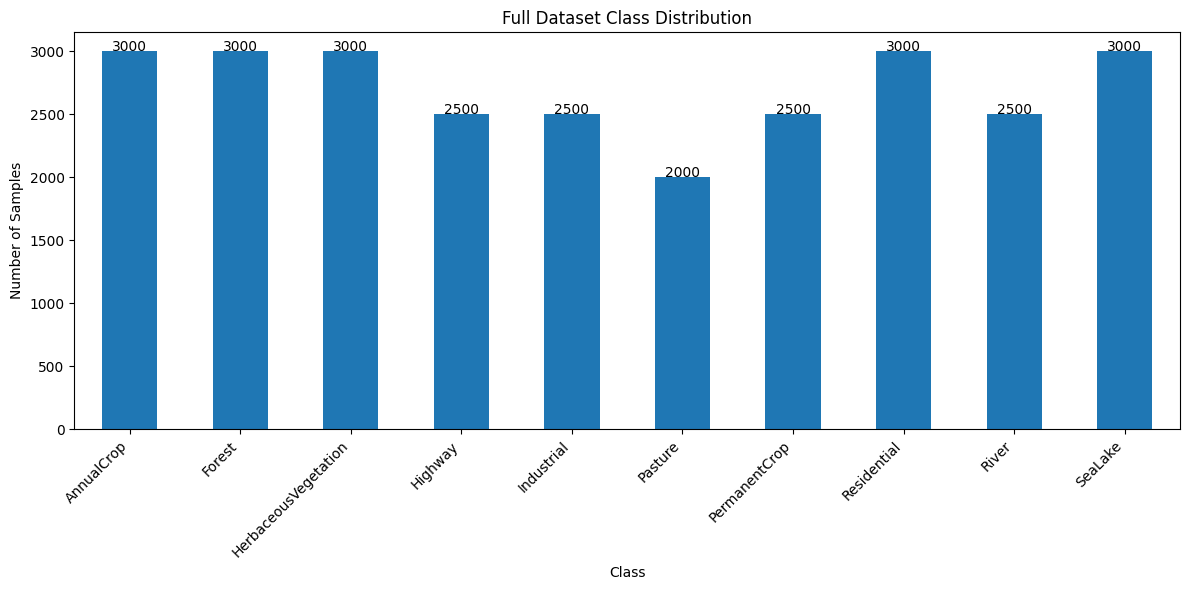

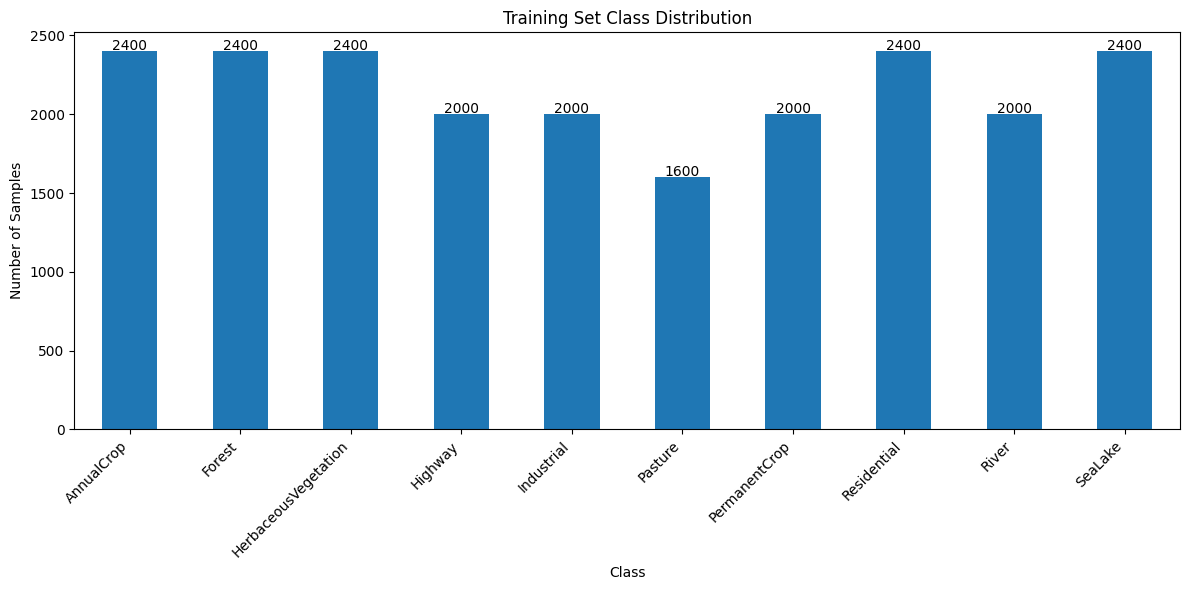

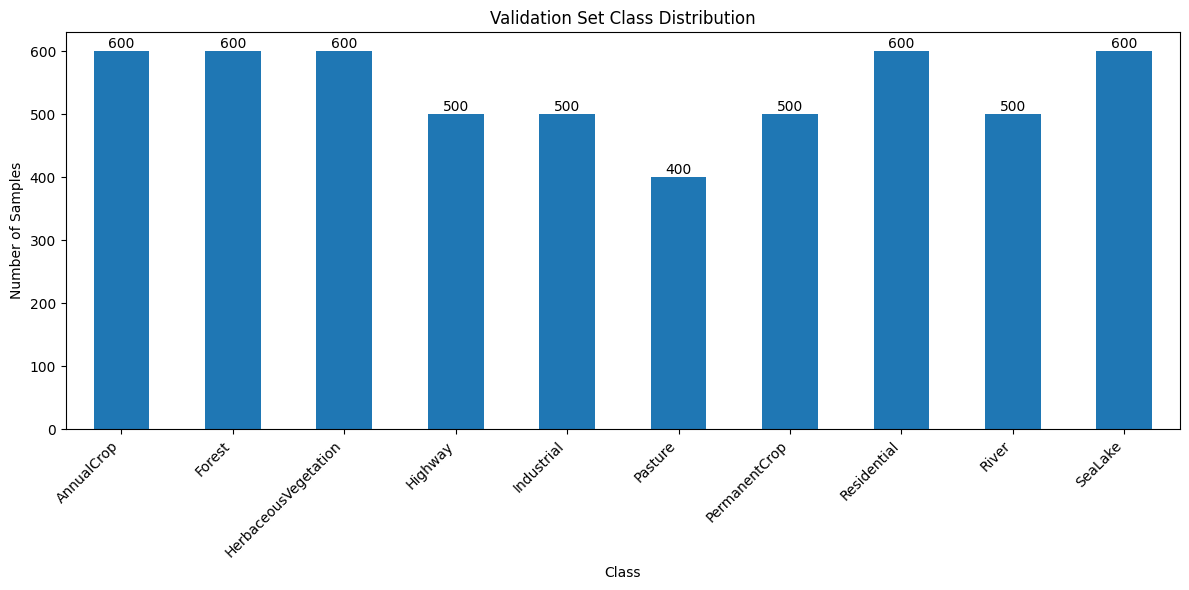

In [7]:
def plot_class_distribution(dataframe, title="Class Distribution"):
    """Visualize the distribution of classes in the dataset"""
    plt.figure(figsize=(12, 6))
    class_counts = dataframe['label'].value_counts().sort_index()
    ax = class_counts.plot(kind='bar')
    plt.title(title)
    plt.ylabel('Number of Samples')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for i, count in enumerate(class_counts):
        ax.text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()

# Plot distribution for entire dataset
plot_class_distribution(df, title="Full Dataset Class Distribution")

# Plot distribution for train/val splits
plot_class_distribution(train_df, title="Training Set Class Distribution")
plot_class_distribution(val_df, title="Validation Set Class Distribution")

# **5: Reproducibility and Data Augmentation Pipeline Setup**

# **5.1: Fix seeds**

In [8]:
import random
import numpy as np
import torch

seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **5.2: Augmentation**

In [9]:
import torch.optim as optim
from torchvision import transforms

# Already computed from your dataset
#mean = [0.18205855758101852, 0.2301079463252315, 0.09464429615162037, 0.3485864438657407]
#std = [0.10013492998282264, 0.11165543609217363, 0.059183771408410114, 0.33000484745181274]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.Resize((64, 64)),
    #transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.Normalize(mean=mean, std=std)
])


# **5.3: Data Augmentation Visualization**

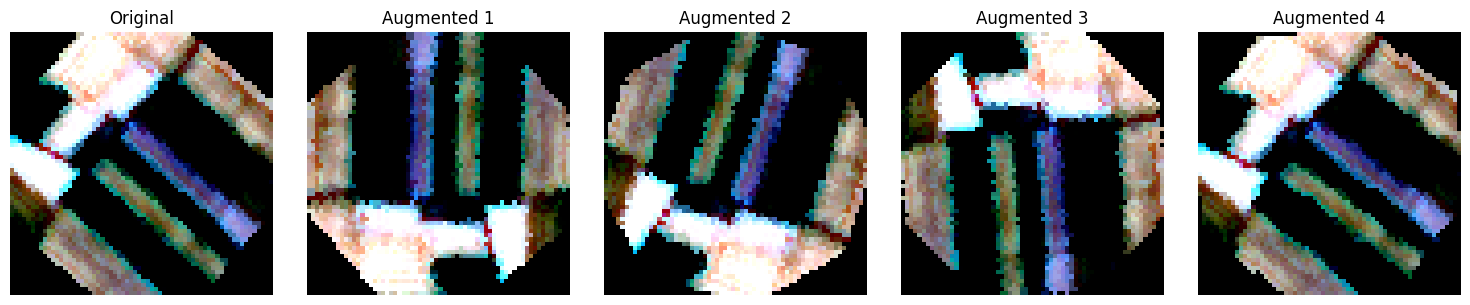

In [ ]:
# Add after defining transforms
# Run cell 6 before running cell 5.3
def visualize_augmentations(dataset, idx=0, num_augmentations=5):
    """Visualize the effect of augmentations on a single sample"""
    sample, _ = dataset[idx]
    
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(3*(num_augmentations+1), 3))
    
    # Original image (using RGB bands)
    rgb_img = np.stack([
        sample[3].numpy(),  # Red
        sample[2].numpy(),  # Green
        sample[1].numpy(),  # Blue
    ], axis=2)
    rgb_img = np.clip(rgb_img, 0, 1)
    
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Apply augmentation multiple times
    for i in range(num_augmentations):
        aug_sample = train_transform(sample)
        
        # Convert to RGB for visualization
        aug_rgb = np.stack([
            aug_sample[3].numpy(),  # Red
            aug_sample[2].numpy(),  # Green
            aug_sample[1].numpy(),  # Blue
        ], axis=2)
        aug_rgb = np.clip(aug_rgb, 0, 1)
        
        axes[i+1].imshow(aug_rgb)
        axes[i+1].set_title(f"Augmented {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize augmentations on a sample
visualize_augmentations(train_ds, idx=0, num_augmentations=4)

# **6: Data Preparation: Dataset and DataLoader Creation**

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

class EuroSATDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sample = np.load(row['path']).astype(np.float32)
        sample = torch.tensor(sample)

        # Calculate mean and std per sample
        mean = sample.mean(dim=[1, 2], keepdim=True)
        std = sample.std(dim=[1, 2], keepdim=True)

        # Normalize the sample
        sample = (sample - mean) / (std + 1e-5)  # Adding a small constant to avoid division by zero

        if self.transform:
            sample = self.transform(sample)

        label = torch.tensor(row['label_idx'], dtype=torch.long)
        return sample, label

train_ds = EuroSATDataset(train_df, transform=train_transform)
val_ds = EuroSATDataset(val_df, transform=val_transform)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True,
    num_workers=2, prefetch_factor=4, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=2, prefetch_factor=4, pin_memory=True
)


# **7: Model Definition and Architecture Details**

# **7.1: Define and Initialize Custom ResNet50 Model (Pretrained = True)**

In [13]:
#%pip install torchgeo

from torchgeo.models.resnet import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

# pick your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet50_MultiChannel(nn.Module):
    def __init__(
        self,
        num_classes: int,
        *,
        # choose a pretrained weight preset here:
        weights: ResNet50_Weights = ResNet50_Weights.SENTINEL2_ALL_SOFTCON
    ):
        super().__init__()
        # load the backbone with pretrained weights
        self.model = resnet50(weights=weights)

        # replace the first conv to accept 16-channel input
        self.model.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        # replace the final FC for your num_classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Example instantiation (e.g. for EuroSAT)
n_classes = df["label_idx"].nunique()
model = ResNet50_MultiChannel(num_classes=n_classes).to(device).eval()


Downloading: "https://huggingface.co/wangyi111/softcon/resolve/62ff465b2e7467dbfc70758ec1e9d08ab87fc46b/B13_rn50_softcon.pth" to /root/.cache/torch/hub/checkpoints/B13_rn50_softcon.pth
100%|██████████| 90.1M/90.1M [00:02<00:00, 36.7MB/s]


# **7.2: Visualize Model Architecture and Parameters**

In [14]:
from torchinfo import summary
import torch.nn as nn

def visualize_model_architecture(model):
    """Create a text-based summary of model architecture"""
    # Create a sample input size matching your data
    input_size = (1, 16, 64, 64)
    
    # Generate comprehensive summary
    model_stats = summary(
        model, 
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        depth=3,
        verbose=1
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model_stats
    
visualize_model_architecture(model)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape
ResNet50_MultiChannel                         [1, 16, 64, 64]           [1, 10]                   --                        --
├─ResNet: 1-1                                 [1, 16, 64, 64]           [1, 10]                   --                        --
│    └─Conv2d: 2-1                            [1, 16, 64, 64]           [1, 64, 32, 32]           50,176                    [7, 7]
│    └─BatchNorm2d: 2-2                       [1, 64, 32, 32]           [1, 64, 32, 32]           128                       --
│    └─ReLU: 2-3                              [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           [1, 64, 16, 16]           --                        3
│    └─Sequential: 2-5                        [1, 64, 16, 16]           [1, 256, 16, 16]          

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape
ResNet50_MultiChannel                         [1, 16, 64, 64]           [1, 10]                   --                        --
├─ResNet: 1-1                                 [1, 16, 64, 64]           [1, 10]                   --                        --
│    └─Conv2d: 2-1                            [1, 16, 64, 64]           [1, 64, 32, 32]           50,176                    [7, 7]
│    └─BatchNorm2d: 2-2                       [1, 64, 32, 32]           [1, 64, 32, 32]           128                       --
│    └─ReLU: 2-3                              [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           [1, 64, 16, 16]           --                        3
│    └─Sequential: 2-5                        [1, 64, 16, 16]           [1, 256, 16, 16]          

# **8: Configure Core Training Components**

In [15]:
import torch.optim as optim 
import torch.nn as nn 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# **9: Define Training and Validation Helper Functions**

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def train_one_epoch(model, loader, optimizer, criterion, device, epoch, log_interval=10):
    model.train()
    total_loss, correct, total = 0, 0, 0
    batch_loss = 0

    for batch_idx, (x, y) in enumerate(loader, 1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        batch_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

        if batch_idx % log_interval == 0:
            avg_loss = batch_loss / log_interval
            print(f"[Epoch {epoch}] Batch {batch_idx:04d} - Avg Loss: {avg_loss:.4f}")
            batch_loss = 0

    return total_loss / total, correct / total

def validate(model, loader, criterion, device, class_names):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(out.argmax(1).cpu().numpy())

    val_acc = correct / total
    print(f"\n Val Acc: {val_acc * 100:.2f}%\n")
    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return total_loss / total, val_acc


# **10: Model Training**

# **10.1: Training Function**

In [17]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt # Make sure this is imported

# Assumptions:
# - ResNet50_MultiChannel class is defined in a previous cell.
# - train_one_epoch and validate functions are defined in previous cells.
# - Your training Dataset object (e.g., train_ds) will be passed to the 'train_ds_for_mapping' parameter.
# - plot_training_progress function is defined.

def run_training(train_loader, val_loader, df, train_ds_for_mapping, num_epochs=10):
    # 1. Define the save directory in Kaggle's output area
    output_base_dir = "/kaggle/working/"
    models_folder_name = "Resnet50 Pretrained Models" # As requested
    full_models_save_path = os.path.join(output_base_dir, models_folder_name)
    
    # Create the directory if it doesn't exist
    os.makedirs(full_models_save_path, exist_ok=True)
    print(f"Models will be saved in: {os.path.abspath(full_models_save_path)}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model (ensure ResNet50_MultiChannel is defined)
    model = ResNet50_MultiChannel(num_classes=df['label_idx'].nunique())

    if torch.cuda.device_count() > 1:
        print(f" Using {torch.cuda.device_count()} GPUs via DataParallel")
        model = nn.DataParallel(model)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    class_names = sorted(df['label'].unique())
    
    # Initialize history lists to store metrics for plotting
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    best_val_acc_tracker = 0.0 # To track overall best accuracy for a final message

    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")

        # Ensure train_one_epoch and validate functions are available
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion, device, class_names)
        
        # Append current epoch's metrics to history lists
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

        # Save the model for the current epoch
        model_filename = f"model_epoch_{epoch:02d}.pth"
        model_filepath = os.path.join(full_models_save_path, model_filename)
        
        model_state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        
        torch.save({
            'epoch': epoch,
            'model_state': model_state_to_save,
            'optimizer_state': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'class_to_idx': train_ds_for_mapping.df[["label", "label_idx"]]
                              .drop_duplicates()
                              .set_index("label_idx")["label"]
                              .to_dict()
        }, model_filepath)
        print(f"Saved model for epoch {epoch} to {model_filepath}")

        if val_acc > best_val_acc_tracker:
            best_val_acc_tracker = val_acc
            # Optional: Announce if this epoch is the new best so far
            # print(f"🎉 New best validation accuracy recorded: {best_val_acc_tracker*100:.2f}%")

        # Display visualization every 5 epochs or on the last epoch
        if epoch % 5 == 0 or epoch == num_epochs:
            print(f"\n--- Plotting training progress at Epoch {epoch} ---")
            plot_training_progress(train_losses, val_losses, train_accs, val_accs)

    print(f"\nTraining complete. Overall best validation accuracy achieved during training: {best_val_acc_tracker*100:.2f}%")
    # Final plot is handled by the condition 'epoch == num_epochs' in the loop

def plot_training_progress(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    axes[0].plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(range(1, len(train_accs) + 1), [acc * 100 for acc in train_accs], 'b-', label='Training Accuracy')
    axes[1].plot(range(1, len(val_accs) + 1), [acc * 100 for acc in val_accs], 'r-', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# **10.2: Lights out 🚦and away we go 🏁🏎️**

Models will be saved in: /kaggle/working/Resnet50 Pretrained Models
 Using 2 GPUs via DataParallel

--- Epoch 1/50 ---
[Epoch 1] Batch 0010 - Avg Loss: 2.2754
[Epoch 1] Batch 0020 - Avg Loss: 2.1738
[Epoch 1] Batch 0030 - Avg Loss: 2.0154
[Epoch 1] Batch 0040 - Avg Loss: 1.8053
[Epoch 1] Batch 0050 - Avg Loss: 1.5719
[Epoch 1] Batch 0060 - Avg Loss: 1.4343
[Epoch 1] Batch 0070 - Avg Loss: 1.2232
[Epoch 1] Batch 0080 - Avg Loss: 1.0660
[Epoch 1] Batch 0090 - Avg Loss: 1.0325
[Epoch 1] Batch 0100 - Avg Loss: 0.9665
[Epoch 1] Batch 0110 - Avg Loss: 0.8669
[Epoch 1] Batch 0120 - Avg Loss: 0.7564
[Epoch 1] Batch 0130 - Avg Loss: 0.7596
[Epoch 1] Batch 0140 - Avg Loss: 0.6880
[Epoch 1] Batch 0150 - Avg Loss: 0.6632
[Epoch 1] Batch 0160 - Avg Loss: 0.5907
[Epoch 1] Batch 0170 - Avg Loss: 0.5392
[Epoch 1] Batch 0180 - Avg Loss: 0.5517
[Epoch 1] Batch 0190 - Avg Loss: 0.5846
[Epoch 1] Batch 0200 - Avg Loss: 0.5655
[Epoch 1] Batch 0210 - Avg Loss: 0.5093
[Epoch 1] Batch 0220 - Avg Loss: 0.5196
[

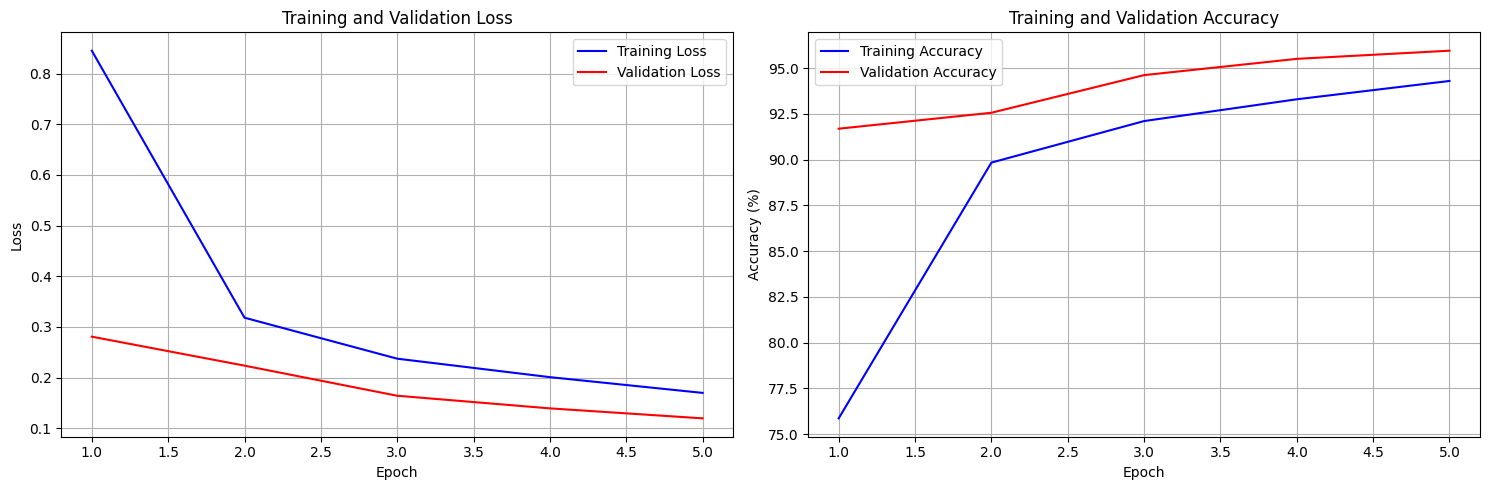


--- Epoch 6/50 ---
[Epoch 6] Batch 0010 - Avg Loss: 0.1306
[Epoch 6] Batch 0020 - Avg Loss: 0.1705
[Epoch 6] Batch 0030 - Avg Loss: 0.1410
[Epoch 6] Batch 0040 - Avg Loss: 0.1305
[Epoch 6] Batch 0050 - Avg Loss: 0.1535
[Epoch 6] Batch 0060 - Avg Loss: 0.1837
[Epoch 6] Batch 0070 - Avg Loss: 0.1249
[Epoch 6] Batch 0080 - Avg Loss: 0.1427
[Epoch 6] Batch 0090 - Avg Loss: 0.1761
[Epoch 6] Batch 0100 - Avg Loss: 0.1294
[Epoch 6] Batch 0110 - Avg Loss: 0.1422
[Epoch 6] Batch 0120 - Avg Loss: 0.1478
[Epoch 6] Batch 0130 - Avg Loss: 0.1345
[Epoch 6] Batch 0140 - Avg Loss: 0.1682
[Epoch 6] Batch 0150 - Avg Loss: 0.1780
[Epoch 6] Batch 0160 - Avg Loss: 0.1474
[Epoch 6] Batch 0170 - Avg Loss: 0.1629
[Epoch 6] Batch 0180 - Avg Loss: 0.1310
[Epoch 6] Batch 0190 - Avg Loss: 0.1167
[Epoch 6] Batch 0200 - Avg Loss: 0.1346
[Epoch 6] Batch 0210 - Avg Loss: 0.1335
[Epoch 6] Batch 0220 - Avg Loss: 0.1313
[Epoch 6] Batch 0230 - Avg Loss: 0.1758
[Epoch 6] Batch 0240 - Avg Loss: 0.1540
[Epoch 6] Batch 0250

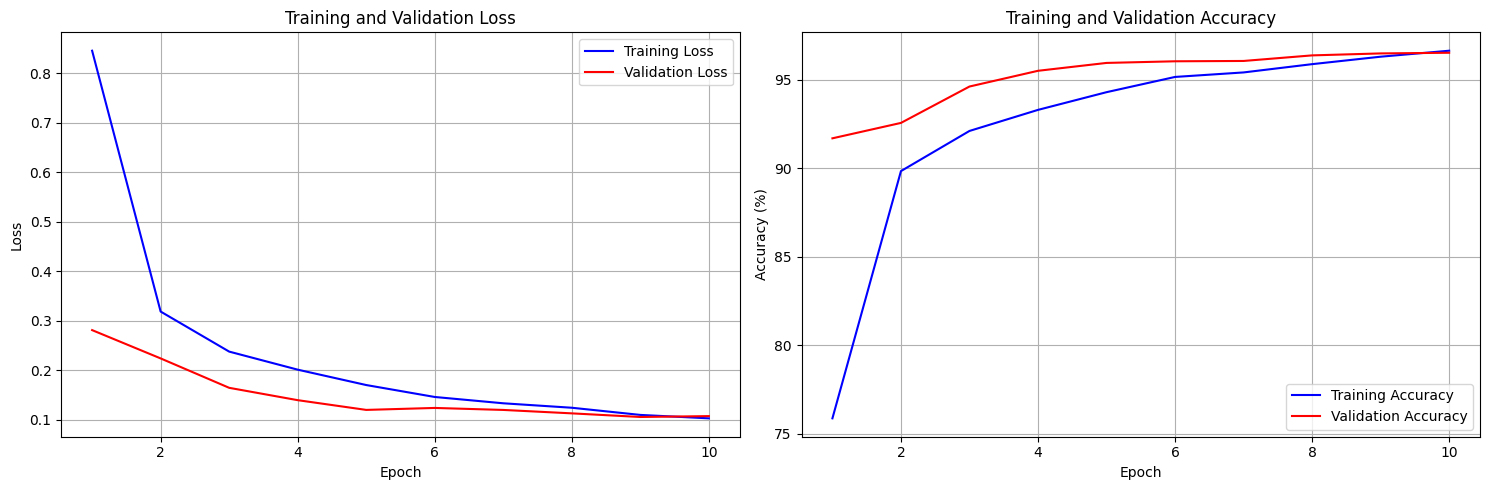


--- Epoch 11/50 ---
[Epoch 11] Batch 0010 - Avg Loss: 0.1229
[Epoch 11] Batch 0020 - Avg Loss: 0.0670
[Epoch 11] Batch 0030 - Avg Loss: 0.1159
[Epoch 11] Batch 0040 - Avg Loss: 0.1113
[Epoch 11] Batch 0050 - Avg Loss: 0.0950
[Epoch 11] Batch 0060 - Avg Loss: 0.1037
[Epoch 11] Batch 0070 - Avg Loss: 0.1102
[Epoch 11] Batch 0080 - Avg Loss: 0.0778
[Epoch 11] Batch 0090 - Avg Loss: 0.0965
[Epoch 11] Batch 0100 - Avg Loss: 0.0987
[Epoch 11] Batch 0110 - Avg Loss: 0.1191
[Epoch 11] Batch 0120 - Avg Loss: 0.0997
[Epoch 11] Batch 0130 - Avg Loss: 0.1541
[Epoch 11] Batch 0140 - Avg Loss: 0.1121
[Epoch 11] Batch 0150 - Avg Loss: 0.1248
[Epoch 11] Batch 0160 - Avg Loss: 0.0678
[Epoch 11] Batch 0170 - Avg Loss: 0.0691
[Epoch 11] Batch 0180 - Avg Loss: 0.0768
[Epoch 11] Batch 0190 - Avg Loss: 0.0828
[Epoch 11] Batch 0200 - Avg Loss: 0.1069
[Epoch 11] Batch 0210 - Avg Loss: 0.0781
[Epoch 11] Batch 0220 - Avg Loss: 0.0856
[Epoch 11] Batch 0230 - Avg Loss: 0.1367
[Epoch 11] Batch 0240 - Avg Loss: 0.

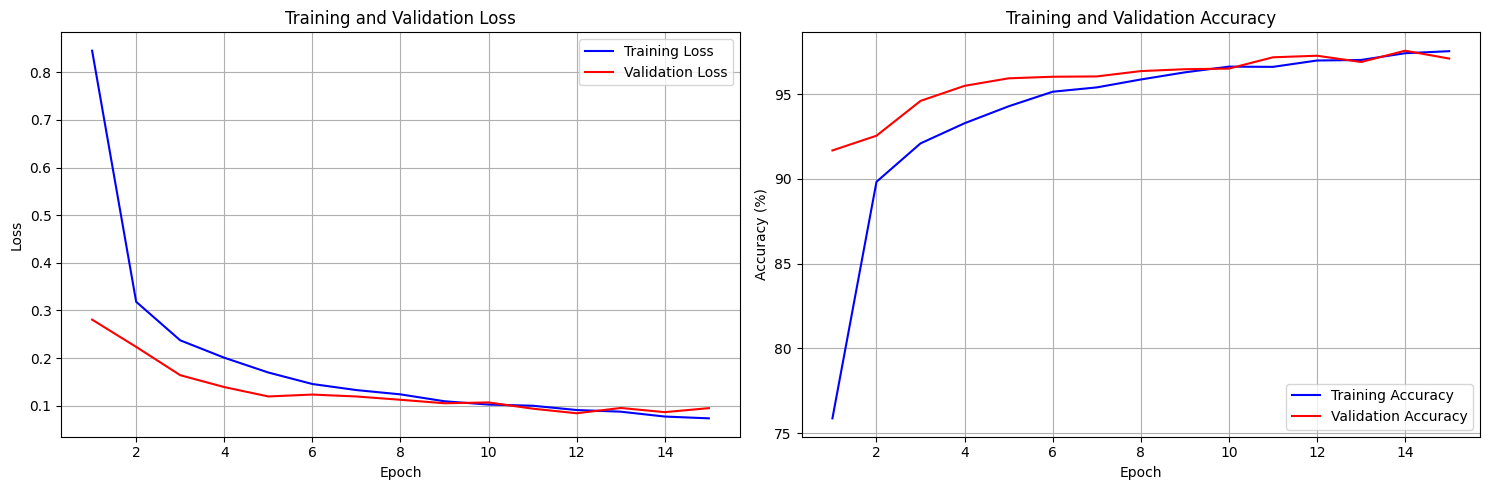


--- Epoch 16/50 ---
[Epoch 16] Batch 0010 - Avg Loss: 0.0736
[Epoch 16] Batch 0020 - Avg Loss: 0.0856
[Epoch 16] Batch 0030 - Avg Loss: 0.0599
[Epoch 16] Batch 0040 - Avg Loss: 0.0682
[Epoch 16] Batch 0050 - Avg Loss: 0.0743
[Epoch 16] Batch 0060 - Avg Loss: 0.0722
[Epoch 16] Batch 0070 - Avg Loss: 0.1062
[Epoch 16] Batch 0080 - Avg Loss: 0.0915
[Epoch 16] Batch 0090 - Avg Loss: 0.0639
[Epoch 16] Batch 0100 - Avg Loss: 0.0701
[Epoch 16] Batch 0110 - Avg Loss: 0.0605
[Epoch 16] Batch 0120 - Avg Loss: 0.0712
[Epoch 16] Batch 0130 - Avg Loss: 0.0616
[Epoch 16] Batch 0140 - Avg Loss: 0.0743
[Epoch 16] Batch 0150 - Avg Loss: 0.0638
[Epoch 16] Batch 0160 - Avg Loss: 0.0996
[Epoch 16] Batch 0170 - Avg Loss: 0.0822
[Epoch 16] Batch 0180 - Avg Loss: 0.0561
[Epoch 16] Batch 0190 - Avg Loss: 0.0775
[Epoch 16] Batch 0200 - Avg Loss: 0.0616
[Epoch 16] Batch 0210 - Avg Loss: 0.0810
[Epoch 16] Batch 0220 - Avg Loss: 0.1079
[Epoch 16] Batch 0230 - Avg Loss: 0.0480
[Epoch 16] Batch 0240 - Avg Loss: 0.

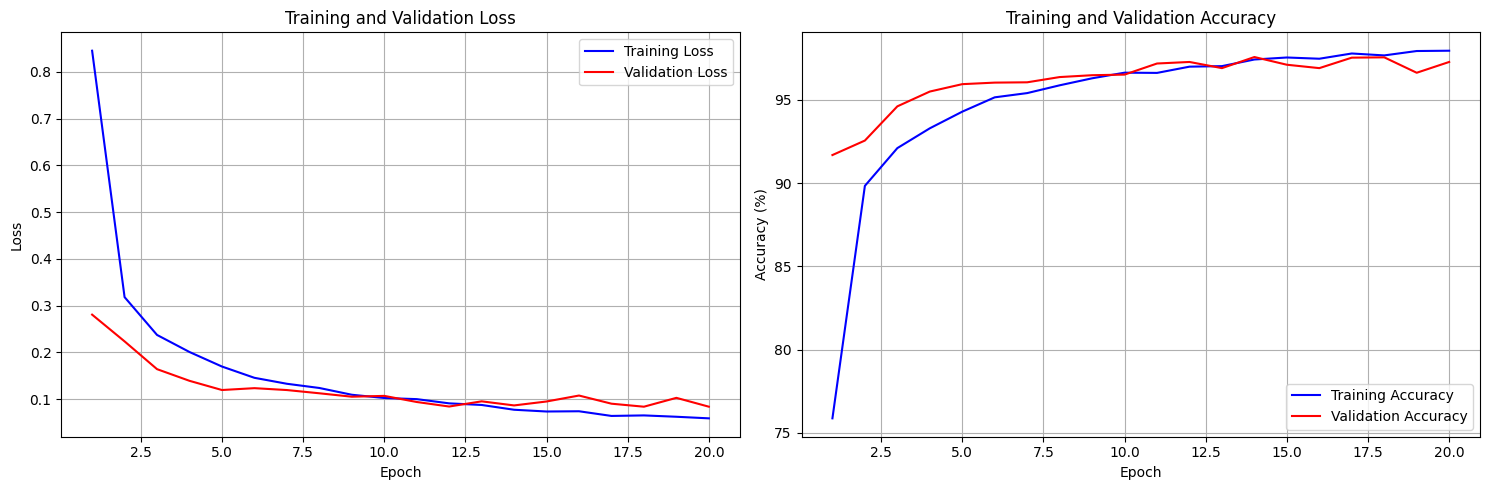


--- Epoch 21/50 ---
[Epoch 21] Batch 0010 - Avg Loss: 0.0845
[Epoch 21] Batch 0020 - Avg Loss: 0.0434
[Epoch 21] Batch 0030 - Avg Loss: 0.0452
[Epoch 21] Batch 0040 - Avg Loss: 0.0502
[Epoch 21] Batch 0050 - Avg Loss: 0.0599
[Epoch 21] Batch 0060 - Avg Loss: 0.0773
[Epoch 21] Batch 0070 - Avg Loss: 0.0552
[Epoch 21] Batch 0080 - Avg Loss: 0.0654
[Epoch 21] Batch 0090 - Avg Loss: 0.0622
[Epoch 21] Batch 0100 - Avg Loss: 0.0396
[Epoch 21] Batch 0110 - Avg Loss: 0.0457
[Epoch 21] Batch 0120 - Avg Loss: 0.0501
[Epoch 21] Batch 0130 - Avg Loss: 0.0535
[Epoch 21] Batch 0140 - Avg Loss: 0.0488
[Epoch 21] Batch 0150 - Avg Loss: 0.0653
[Epoch 21] Batch 0160 - Avg Loss: 0.0411
[Epoch 21] Batch 0170 - Avg Loss: 0.0483
[Epoch 21] Batch 0180 - Avg Loss: 0.0415
[Epoch 21] Batch 0190 - Avg Loss: 0.0918
[Epoch 21] Batch 0200 - Avg Loss: 0.0503
[Epoch 21] Batch 0210 - Avg Loss: 0.0544
[Epoch 21] Batch 0220 - Avg Loss: 0.0578
[Epoch 21] Batch 0230 - Avg Loss: 0.0648
[Epoch 21] Batch 0240 - Avg Loss: 0.

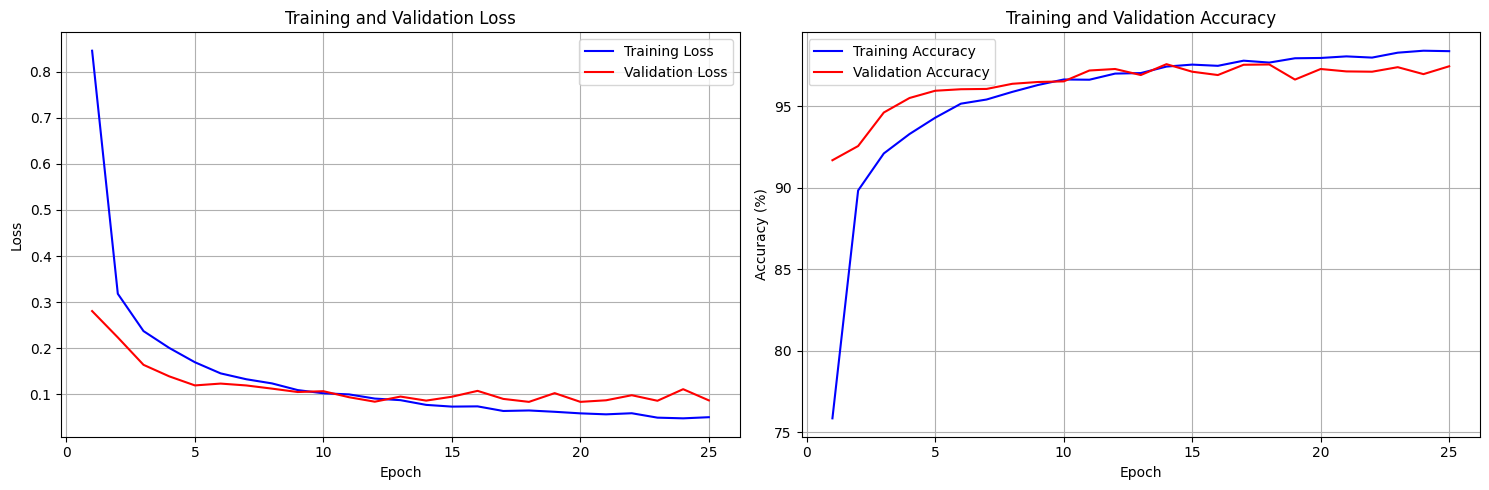


--- Epoch 26/50 ---
[Epoch 26] Batch 0010 - Avg Loss: 0.0343
[Epoch 26] Batch 0020 - Avg Loss: 0.0504
[Epoch 26] Batch 0030 - Avg Loss: 0.0306
[Epoch 26] Batch 0040 - Avg Loss: 0.0309
[Epoch 26] Batch 0050 - Avg Loss: 0.0562
[Epoch 26] Batch 0060 - Avg Loss: 0.0484
[Epoch 26] Batch 0070 - Avg Loss: 0.0393
[Epoch 26] Batch 0080 - Avg Loss: 0.0312
[Epoch 26] Batch 0090 - Avg Loss: 0.0537
[Epoch 26] Batch 0100 - Avg Loss: 0.0384
[Epoch 26] Batch 0110 - Avg Loss: 0.0866
[Epoch 26] Batch 0120 - Avg Loss: 0.0603
[Epoch 26] Batch 0130 - Avg Loss: 0.0420
[Epoch 26] Batch 0140 - Avg Loss: 0.0233
[Epoch 26] Batch 0150 - Avg Loss: 0.0613
[Epoch 26] Batch 0160 - Avg Loss: 0.0347
[Epoch 26] Batch 0170 - Avg Loss: 0.0422
[Epoch 26] Batch 0180 - Avg Loss: 0.0485
[Epoch 26] Batch 0190 - Avg Loss: 0.0561
[Epoch 26] Batch 0200 - Avg Loss: 0.0507
[Epoch 26] Batch 0210 - Avg Loss: 0.0335
[Epoch 26] Batch 0220 - Avg Loss: 0.0421
[Epoch 26] Batch 0230 - Avg Loss: 0.0684
[Epoch 26] Batch 0240 - Avg Loss: 0.

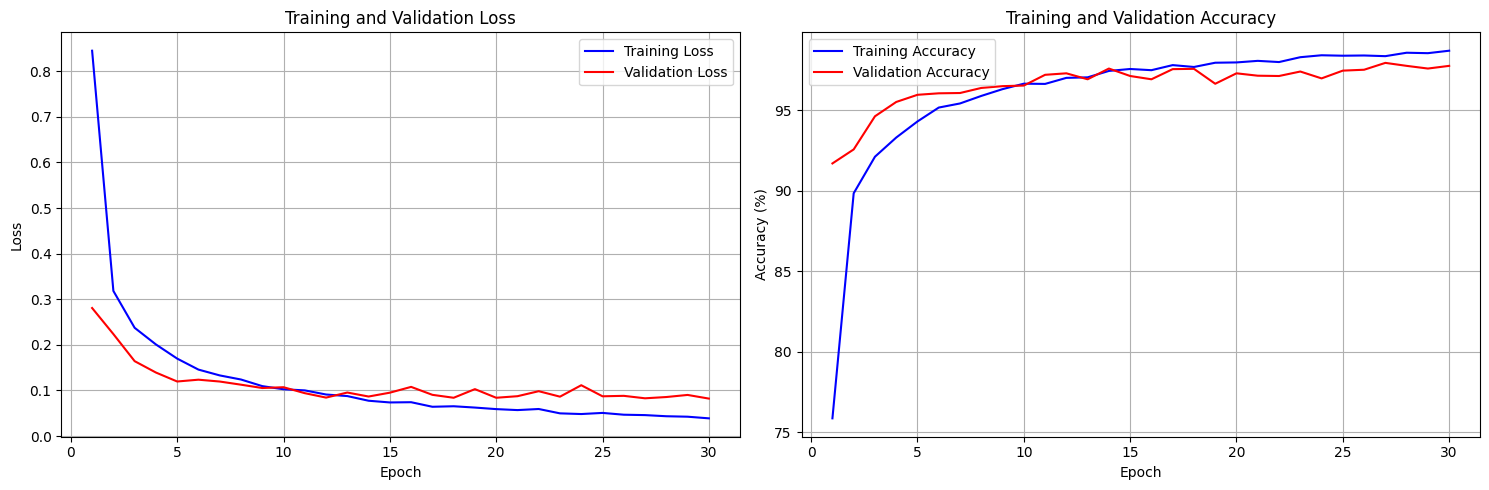


--- Epoch 31/50 ---
[Epoch 31] Batch 0010 - Avg Loss: 0.0410
[Epoch 31] Batch 0020 - Avg Loss: 0.0486
[Epoch 31] Batch 0030 - Avg Loss: 0.0640
[Epoch 31] Batch 0040 - Avg Loss: 0.0647
[Epoch 31] Batch 0050 - Avg Loss: 0.0190
[Epoch 31] Batch 0060 - Avg Loss: 0.0449
[Epoch 31] Batch 0070 - Avg Loss: 0.0370
[Epoch 31] Batch 0080 - Avg Loss: 0.0181
[Epoch 31] Batch 0090 - Avg Loss: 0.0608
[Epoch 31] Batch 0100 - Avg Loss: 0.0440
[Epoch 31] Batch 0110 - Avg Loss: 0.0354
[Epoch 31] Batch 0120 - Avg Loss: 0.0272
[Epoch 31] Batch 0130 - Avg Loss: 0.0518
[Epoch 31] Batch 0140 - Avg Loss: 0.0446
[Epoch 31] Batch 0150 - Avg Loss: 0.0411
[Epoch 31] Batch 0160 - Avg Loss: 0.0401
[Epoch 31] Batch 0170 - Avg Loss: 0.0204
[Epoch 31] Batch 0180 - Avg Loss: 0.0326
[Epoch 31] Batch 0190 - Avg Loss: 0.0234
[Epoch 31] Batch 0200 - Avg Loss: 0.0353
[Epoch 31] Batch 0210 - Avg Loss: 0.0349
[Epoch 31] Batch 0220 - Avg Loss: 0.0481
[Epoch 31] Batch 0230 - Avg Loss: 0.0472
[Epoch 31] Batch 0240 - Avg Loss: 0.

RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 193193152 vs 193193044

In [18]:
run_training(train_loader, val_loader, df, train_ds, num_epochs=50)

# **11: Inference + Submission**

# **11.1: Load Best Model**

In [29]:
best_model_path = "/kaggle/working/Resnet50 Pretrained Models/model_epoch_10.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣  Load the checkpoint
ckpt = torch.load(best_model_path, map_location=device)

# 2️⃣  Get the actual weight dict
state_dict = ckpt.get("state_dict", ckpt)          # Lightning-style or plain

# 3️⃣  Clean up the keys
clean_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."): k = k[7:]          # drop 'module.'
    if k.startswith("model."):  k = k[6:]          # drop 'model.'
    clean_state_dict[k] = v

# 4️⃣  Build the model and load weights (non-strict so extras are ignored)
model = ResNet50_MultiChannel(num_classes=df["label_idx"].nunique())
missing, unexpected = model.load_state_dict(clean_state_dict, strict=False)

print("Missing keys :", missing)      # should be [] if arch is identical
print("Unexpected   :", unexpected)   # safely ignored

model.to(device).eval()

Missing keys : ['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.bn1.running_mean', 'model.layer1.0.bn1.running_var', 'model.layer1.0.conv2.weight', 'model.layer1.0.bn2.weight', 'model.layer1.0.bn2.bias', 'model.layer1.0.bn2.running_mean', 'model.layer1.0.bn2.running_var', 'model.layer1.0.conv3.weight', 'model.layer1.0.bn3.weight', 'model.layer1.0.bn3.bias', 'model.layer1.0.bn3.running_mean', 'model.layer1.0.bn3.running_var', 'model.layer1.0.downsample.0.weight', 'model.layer1.0.downsample.1.weight', 'model.layer1.0.downsample.1.bias', 'model.layer1.0.downsample.1.running_mean', 'model.layer1.0.downsample.1.running_var', 'model.layer1.1.conv1.weight', 'model.layer1.1.bn1.weight', 'model.layer1.1.bn1.bias', 'model.layer1.1.bn1.running_mean', 'model.layer1.1.bn1.running_var', 'model.layer1.1.conv2.weight', 'model.layer1.1.bn2

ResNet50_MultiChannel(
  (model): ResNet(
    (conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, ep

# **11.2: Build Class Index → Label Mapping**

In [ ]:
!unzip -q testset.zip -d TestSet

In [ ]:
##idx_to_class = {v: k for k, v in df[['label', 'label_idx']].drop_duplicates().set_index('label').to_dict()['label_idx'].items()}


# **3. Inference on Test NPY Files**

In [23]:
test_dir = "/kaggle/input/testset/testset/testset"

In [24]:
import os
from glob import glob

print("Exists:", os.path.exists(test_dir))
print("Files found:", len(glob(os.path.join(test_dir, "*.npy"))))


Exists: True
Files found: 4232


In [ ]:
#mean = torch.tensor([0.1821, 0.2301, 0.0946, 0.3486], device=device).view(4, 1, 1)
#std = torch.tensor([0.1001, 0.1117, 0.0592, 0.3300], device=device).view(4, 1, 1)


# **11.4: Inference Run**

In [ ]:
import os
import numpy as np
import torch
from tqdm import tqdm

test_dir = "/kaggle/input/testset/testset/testset"
ckpt = torch.load("/kaggle/working/Resnet50 Pretrained Models/model_epoch_10.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
idx_to_class = ckpt["class_to_idx"]      # <-- guaranteed to match training
model.eval()
test_files = sorted(glob(os.path.join(test_dir, "*.npy")))

#mean = torch.tensor([0.1821, 0.2301, 0.0946, 0.3486], device=device).view(4, 1, 1)
#std = torch.tensor([0.1001, 0.1117, 0.0592, 0.3300], device=device).view(4, 1, 1)

results = []

def process_test_data(path):
    x = np.load(path).astype(np.float32)
    x = np.transpose(x, (2, 0, 1))
    # No transpose needed, assuming the input is (C, H, W) after loading

    # Raw bands (scaled to 0-1)
    selected_indices = [1,2,3,4,5,6,7,9,10,11,8]   # B1-B9, B11-B8a
    raw_bands = x[selected_indices] / 10000.0

    # Indices
    B3, B4, B8, B11 = x[2], x[3], x[7], x[11]   # note: indices w.r.t selected set
    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
    ndbi = (B11 - B8) / (B11 + B8 + 1e-6)
    ndmi = (B8 - B11) / (B8 + B11 + 1e-6)
    savi = (1.5 * (B8 - B4)) / (B8 + B4 + 0.5)


    indices = np.stack([ndvi, ndwi, ndbi, ndmi, savi], axis=0)
    indices = np.clip(indices, -1, 1)

    x_final = np.concatenate([raw_bands, indices], axis=0).astype(np.float32)
    x_final = torch.tensor(x_final)

    #x_final = torch.nn.functional.interpolate(
     #       torch.tensor(x_final).unsqueeze(0),
      #      size=(64, 64),
       #     mode="bilinear",
        #    align_corners=False
         # ).squeeze(0)

    # Calculate mean and std per sample
    mean = x_final.mean(dim=[1, 2], keepdim=True)
    std = x_final.std(dim=[1, 2], keepdim=True)

    # Normalize the sample
    x_final = (x_final - mean) / (std + 1e-5)  # Adding a small constant to avoid division by zero

    return x_final


# Update inference loop
with torch.no_grad():
    for path in tqdm(test_files, desc="Running Inference"):
        x_final = process_test_data(path)
        x_final = x_final.to(device, dtype=torch.float32)
        x_final = x_final.unsqueeze(0)

        out = model(x_final)
        pred = out.argmax(1).item()
        label = idx_to_class[pred]
        results.append((os.path.basename(path).replace(".npy", ""), label))


Running Inference: 100%|██████████| 4232/4232 [00:35<00:00, 118.17it/s]


# **11.5. Submission Generation**

In [31]:
import pandas as pd

# 'results' contains tuples like: [('test_0', 'Forest'), ('test_1', 'River'), ...]

# Convert to DataFrame with correct format
submission_df = pd.DataFrame(results, columns=["test_id", "label"])

# Extract numeric part of test_id and convert to int
submission_df["test_id"] = submission_df["test_id"].str.extract(r"(\d+)").astype(int)

# Sort by test_id to match sample_submission.csv order
submission_df = submission_df.sort_values("test_id").reset_index(drop=True)

# Save to CSV
submission_df.to_csv("submission_pretrained_10.csv", index=False)


# **11.6: Class Counter**

In [32]:
from collections import Counter

# Extract just the predicted labels
predicted_labels = [label for _, label in results]

# Count occurrences of each class
class_counts = Counter(predicted_labels)

# Get all possible classes (in case some are missing from predictions)
all_classes = sorted(idx_to_class.values())

print("\nPredicted class distribution:")
for class_name in all_classes:
    count = class_counts.get(class_name, 0)
    print(f"{class_name}: {count}")



Predicted class distribution:
AnnualCrop: 200
Forest: 471
HerbaceousVegetation: 471
Highway: 424
Industrial: 303
Pasture: 374
PermanentCrop: 695
Residential: 835
River: 203
SeaLake: 256


# **11.6: Test Prediction Distribution**

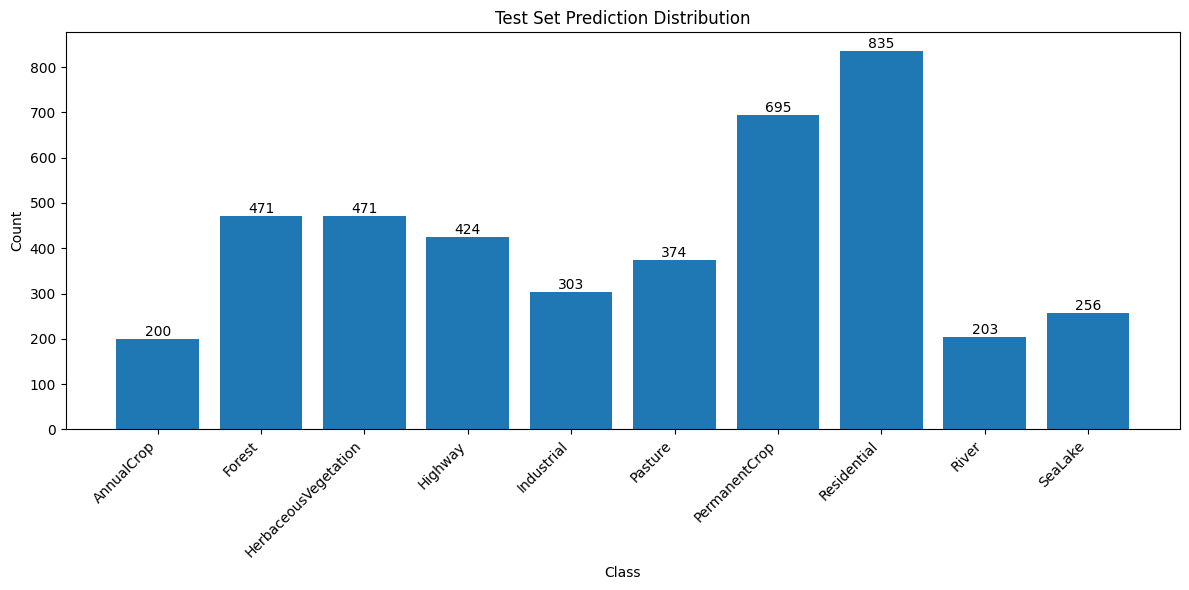

In [33]:
# Add after calculating class counts
def plot_test_distribution(class_counts, all_classes):
    """Plot distribution of predicted classes in test set"""
    plt.figure(figsize=(12, 6))
    counts = [class_counts.get(cls, 0) for cls in all_classes]
    
    bars = plt.bar(all_classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Test Set Prediction Distribution')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Plot test prediction distribution
plot_test_distribution(class_counts, all_classes)